### halo ratio (?) function
looking at $N/N_{CDM}$ for both $z = 0$ and $z= rel.$, with mass remaining fixed and z as the independent variable. might be an interesting probe to see how scale suppression comes into play for different models.

(cont. from the w3 notebook)

In [1]:
import os
import numpy as np
import pickle
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist
import matplotlib.pylab as plt
from cycler import cycler

#......new imports (helper class)
import sys
sys.path.insert(0, '../scripts') # adding to the system path
from hlistHelper import hlist

#......formatting
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'cm'

In [2]:
# with open("../data/sim_data.bin", "rb") as f:
#     sim_data = pickle.load(f, encoding='latin1')

#...... cold dark matter
model = 'cdm'
halo_id = 'Halo004'

cdm = hlist(halo_id=halo_id, model=model)
cdm.load_hlists()
cdm.load_hmb()
# cdm.hmb = sim_data[halo_num][model][0]

#...... warm dark matter, 3 keV
model = 'wdm_3'
wdm = hlist(halo_id=halo_id, model=model)
wdm.load_hlists()
wdm.load_hmb()
# wdm.hmb = sim_data[halo_num][model][0]

#### ---- original functions

In [ ]:
# TODO: come back to fix this (overflow error?)

def get_ratio(model: hlist = cdm, m: float = 0):
    a_range = [ a for a in list(model.dict.keys()) if (1.0/a) - 1.0 < 4.5]

    m = np.log10(m) # converting to log10
    ratios = np.zeros((len(a_range), ))

    halos_cdm, subhalos_cdm = model.get_z(0)
    values_cdm, cumulative_cdm, base_cdm, mass_cut_cdm = cdm.shmf(0, return_masscut_idx=True)
    mass_ind = np.argmin(np.abs(base_cdm - m))

    for i, a in enumerate(a_range):
        
        halos, subhalos = model.get_a(a)
        values, cumulative, base, mass_cut = model.shmf( (1.0/a) - 1.0, return_masscut_idx=True)
        temp = (1.*len(subhalos['Mpeak'][mass_cut])-cumulative)/(1.*len(subhalos_cdm['Mpeak'][mass_cut_cdm])-cumulative_cdm)
        ratios[i] = temp[mass_ind]

    return ratios, [(1.0/a) - 1.0 for a in a_range]

def get_ratio_relative_z(model: hlist = cdm, m: float = 0):
    a_range = [ a for a in list(model.dict.keys()) if (1.0/a) - 1.0 < 4.5]
    z_range = [(1.0/a) - 1.0 for a in a_range]

    m = np.log10(m) # converting to log10
    ratios = np.zeros((len(a_range), ))

    for i, a in enumerate(a_range):

        halos_cdm, subhalos_cdm = model.get_a(a)
        values_cdm, cumulative_cdm, base_cdm, mass_cut_cdm = cdm.shmf((1.0/a) - 1.0, return_masscut_idx=True)
        mass_ind = np.argmin(np.abs(base_cdm - m))
        
        halos, subhalos = model.get_a(a)
        values, cumulative, base, mass_cut = model.shmf( (1.0/a) - 1.0, return_masscut_idx=True)
        temp = (1.*len(subhalos['Mpeak'][mass_cut])-cumulative)/(1.*len(subhalos_cdm['Mpeak'][mass_cut_cdm])-cumulative_cdm)
        ratios[i] = temp[mass_ind]
        print('.', sep='',end='')

    return ratios, z_range
        
r_new, z_new = get_ratio_relative_z(wdm, 1e9)

#### ----- updating functions

In [3]:
def get_relative_number(model: hlist = cdm, mass: float = 1e8, bin_percent: float = 0.1, z_cutoff: float = 4.5, relative_z: bool = False, cdm_ratio: bool = True):

    '''
    Calculates the relative number of subhalos (N/N_CDM) for both CDM at z = 0 and z = rel. as a function of redshift within range of a defined mass (default bin is narrow, +/- 0.1). Also allows for user defined adjustment of the upper redshift limit (default is z = 4.5)
    '''
    
    a_range = [ a for a in list(model.dict.keys()) if (1.0/a) - 1.0 < z_cutoff] # gets all scale factors below cutoff
    ratios = np.zeros((len(a_range), ))

    for i, a in enumerate(a_range):

        # get subhalos
        halos, subhalos = model.get_a(a)
        
        if cdm_ratio:

            if relative_z:
                halos_cdm, subhalos_cdm = cdm.get_a(a) # normalized to cdm at z = rel.
            else:
                halos_cdm, subhalos_cdm = cdm.get_a(1) # normalized to cdm at z = 0

            # get subhalos only within 0.1 (or user defined bin) of the desired mass
            a = subhalos['Mpeak']/0.7 > (1 - bin_percent)*mass 
            b = subhalos['Mpeak']/0.7 < (1 + bin_percent)*mass
            mass_cut_ind = a == b
            n = np.sum(mass_cut_ind)

            # get relavant CDM subhalos (either at z = 0 or z = relative)
            a = subhalos_cdm['Mpeak']/0.7 > (1 - bin_percent)*mass 
            b = subhalos_cdm['Mpeak']/0.7 < (1 + bin_percent)*mass
            mass_cut_ind_cdm = a == b
            n_cdm = np.sum(mass_cut_ind_cdm)

            ratios[i] = n/n_cdm # calculates the numerical ratio
            
        else:

            halos_wdm, subhalos_wdm = model.get_a(1) # normalized to wdm at z = 0

            # get subhalos only within 0.1 (or user defined bin) of the desired mass
            a = subhalos['Mpeak']/0.7 > (1 - bin_percent)*mass 
            b = subhalos['Mpeak']/0.7 < (1 + bin_percent)*mass
            mass_cut_ind = a == b
            n = np.sum(mass_cut_ind)

            # get relavant CDM subhalos (either at z = 0 or z = relative)
            a = subhalos_wdm['Mpeak']/0.7 > (1 - bin_percent)*mass 
            b = subhalos_wdm['Mpeak']/0.7 < (1 + bin_percent)*mass
            mass_cut_ind_cdm = a == b
            n_wdm = np.sum(mass_cut_ind_wdm)

            ratios[i] = n/n_wdm # calculates the numerical ratio
            

    return ratios, [(1.0/a) - 1.0 for a in a_range]

In [ ]:
mass = 9

r, z = get_relative_number(cdm, (10**mass))
r_wdm, z_wdm = get_relative_number(wdm, (10**mass))
plt.figure(figsize=(8,8))
plt.plot(z, r, c='teal', label=r'$CDM$')
plt.plot(z_wdm, r_wdm, c='darkorange', label=r'$WDM_3$')
plt.xlabel(r'$z$', fontsize=18)
plt.ylabel(r'$N/N_{CDM_{z=0}}$', fontsize=18)
plt.text(4, 0.8, r'$10^{9} M_{\odot}$', fontsize=18)
plt.legend(fontsize=16)

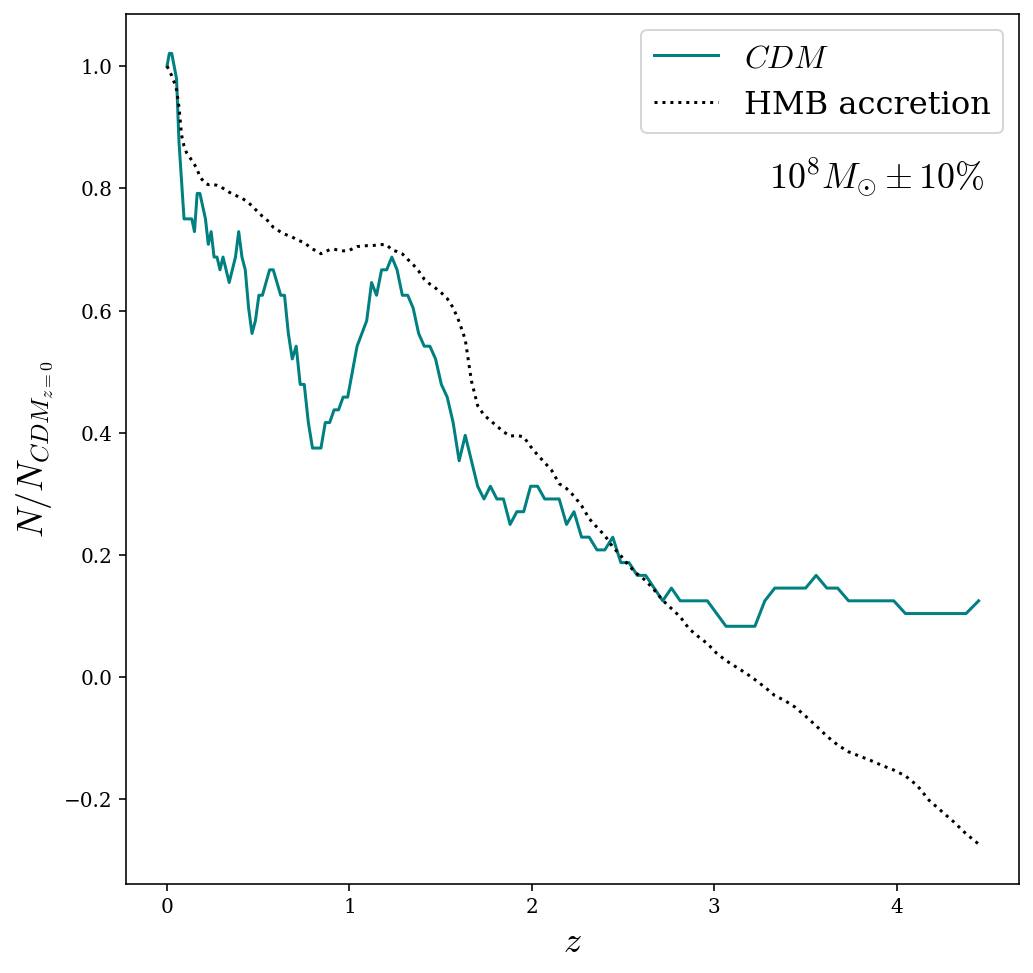

In [28]:
mass = 8

r, z = get_relative_number(cdm, (10**mass), bin_percent = 0.1)

redshift_cut = 1./cdm.hmb['scale'] - 1. < 4.5

z_hmb = 1./cdm.hmb['scale'] - 1.
mass_hmb = np.log10(cdm.hmb['mvir']/cdm.hmb['mvir'][0]) # virial mass


plt.figure(figsize=(8,8))
plt.plot(z, r, c='teal', label=r'$CDM$')
plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut] + 1, label='HMB accretion', c='k', linestyle=':')
# plt.plot(z_wdm, r_wdm, c='darkorange', label=r'$WDM_3$')
plt.xlabel(r'$z$', fontsize=18)
plt.ylabel(r'$N/N_{CDM_{z=0}}$', fontsize=18)
plt.text(3.3, 0.8, r'$10^{8} M_{\odot} \pm 10\%$', fontsize=18)
plt.legend(fontsize=16)

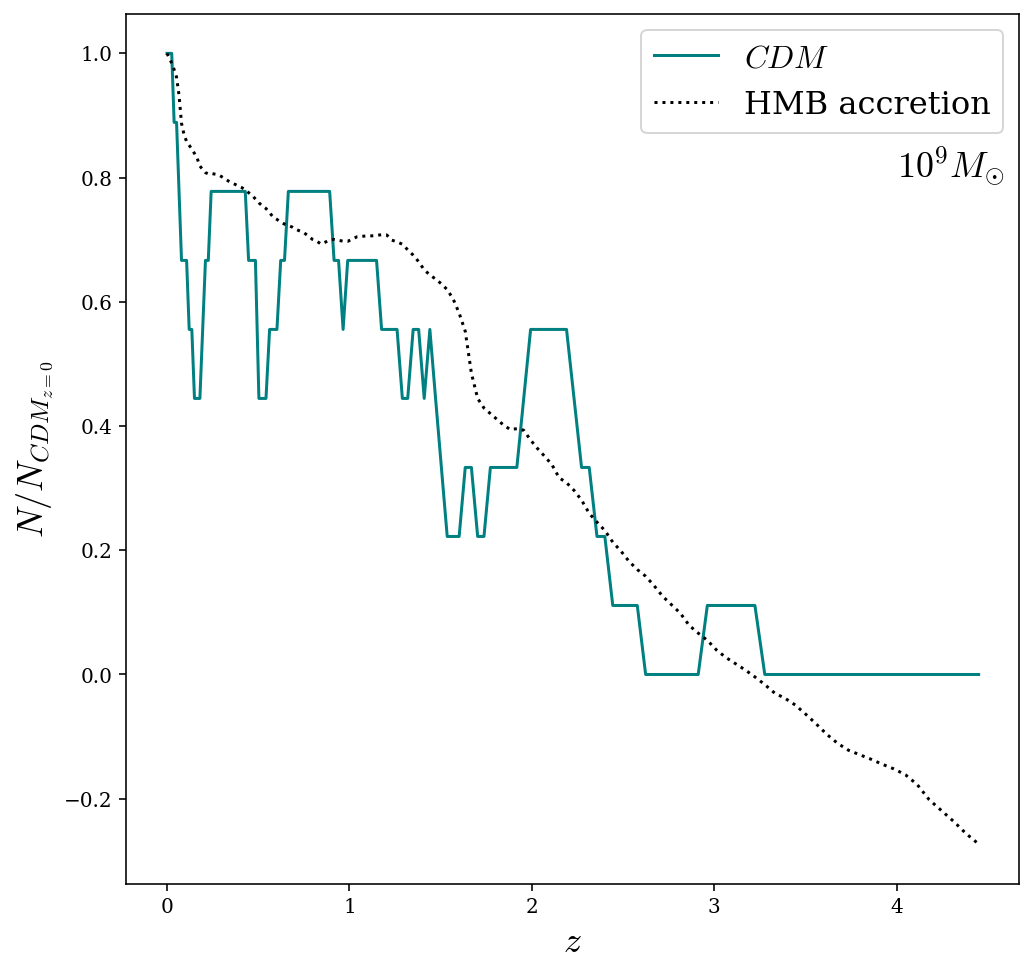

In [24]:
mass = 9

r, z = get_relative_number(cdm, (10**mass), bin_percent = 0.5)

redshift_cut = 1./cdm.hmb['scale'] - 1. < 4.5

z_hmb = 1./cdm.hmb['scale'] - 1.
mass_hmb = np.log10(cdm.hmb['mvir']/cdm.hmb['mvir'][0]) # virial mass


plt.figure(figsize=(8,8))
plt.plot(z, r, c='teal', label=r'$CDM$')
plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut] + 1, label='HMB accretion', c='k', linestyle=':')
# plt.plot(z_wdm, r_wdm, c='darkorange', label=r'$WDM_3$')
plt.xlabel(r'$z$', fontsize=18)
plt.ylabel(r'$N/N_{CDM_{z=0}}$', fontsize=18)
plt.text(4, 0.8, r'$10^{9} M_{\odot} \pm 50\%$', fontsize=18)
plt.legend(fontsize=16)